### Flow Rate

A model circuit is depicted featuring two point-like elements: a heater and a cooler, which exchange constant power with the external environment. The circular section is constant, and the walls are adiabatic. We also assume that the flow rate is steady, and the concentrated losses have a total contribution equal to 2. The flow rate is given by the following formula:

\begin{equation*}
\dot{m} = \sqrt[3]{\frac{2 \rho_0^2 g \beta A^2 \dot{Q} H}{c_p \left( 2 + f \frac{L}{D} \right)}}
\end{equation*}

The flow rate depends on the Darcy friction factor, which varies with the Reynolds number as described by the Moody Chart:

\begin{equation*}
f(Re) =
\begin{cases}
\frac{64}{Re} & \text{for } Re < 2300  \\
\frac{0.25}{\left[  \log_{10} \left( \frac{r}{3.7} + \frac{5.74}{Re^{0.9}}  \right)  \right]^2} & \text{for } Re \geq 2300 \
\end{cases}
\end{equation*}

The Reynolds number depends on the flow rate itself:

\begin{equation*}
Re(\dot{m}) = \frac{4}{\pi D} \frac{\dot{m}}{\mu}
\end{equation*}

It's evident that an iterative approach is necessary to calculate all these quantities: starting from an initial flow rate value, the Reynolds number is then calculated. Subsequently, the friction factor is evaluated, and the flow rate is recalculated again, and the cycle continues until convergence is achieved.

In [99]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-dark')

In [100]:
# Number of iterations (fast convergence)
N = 10

# Fixed parameters of the circuit
L = 50.0  # Length
D = L / 100   # Diameter
A = np.pi * ((D / 2) ** 2)  # Area
H = L / 2.5   # Gap
eps = 0.000015  # Roughness of stainless steel
r = eps / D  # Relative roughness

Q_dot = 1e05  # Heat transfer

# Molten lead thermodynamic constants (T = 400 °C, P = 1 atm)
mu = 0.002227 # Dynamic viscosity
ro = 10580.0 # Density
beta = 0.0001209 # Thermal expansion coefficient at constant pressure
c_p = 146.7 # Specific heat capacity at constant pressure

g = 9.81  # Gravity acceleration

In [101]:
# List of functions
def Reynolds(m_dot):  # Calculating the Reynolds number
    return (4 * m_dot) / (np.pi * D * mu)

def Darcy(Rey): # Calculating the Darcy frictional factor
    if Rey < 2300: # Laminar flow
        x = 64 / Rey  
    else: # Turbulent flow
        x = 0.25 / ((np.log10((r / 3.7) + (5.74 / (Rey ** 0.9)))) ** 2)
    return x

def M_dot(f, Q_dot): # Calculating the flow rate
    return np.cbrt((2 * (ro ** 2) * g * beta * (A ** 2) * Q_dot * H) / (c_p * (2 + ((f * L) / D))))

In [102]:
# Starting the simulation 
m_dot_initial = np.arange(50, 650, 30) # Different initial values of the flow rate
y = np.zeros((N, len(m_dot_initial)))
m_dot = np.copy(m_dot_initial)

for j in range(len(m_dot)):
    for i in range(N):
        Rey = Reynolds(m_dot[j])
        F = Darcy(Rey)
        new_m_dot = M_dot(F, Q_dot)

        m_dot[j] = new_m_dot
        y[i][j] = new_m_dot

v = new_m_dot / (A * ro) # Computing final flow velocity
T = Q_dot / (c_p * new_m_dot) # Computing final temperature difference

In [103]:
# Printing the final results
print(f"Flow rate: m_dot = {new_m_dot:.1f} Kg \ s")
print(f"Reynolds number: Re = {Rey:.1e}")
print(f"Darcy factor: f = {F:.3f}")
print(f"Flow velocity: v = {v:.2f} m \ s")
print(f"Temperature difference: {T:.1f} °C")

Flow rate: m_dot = 344.7 Kg \ s
Reynolds number: Re = 3.9e+05
Darcy factor: f = 0.014
Flow velocity: v = 0.17 m \ s
Temperature difference: 2.0 °C


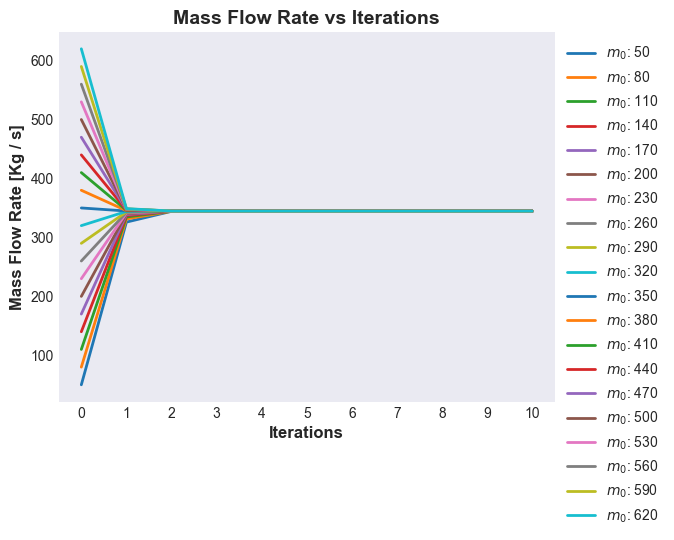

In [104]:
# Plotting results
[plt.plot(np.insert(y[:, j], 0, m_dot_initial[j]), label= f"$m_0$: {m_dot_initial[j]}", linewidth= 2) for j in range(len(m_dot_initial))]

plt.xlabel("Iterations", fontweight= "bold", fontsize= 12)
plt.xticks(ticks= np.arange(N + 1))
plt.ylabel("Mass Flow Rate [Kg / s]", fontweight= "bold", fontsize= 12)
plt.title("Mass Flow Rate vs Iterations", fontweight= "bold", fontsize= 14)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Now we are going to plot the characteristic curve of the flow rate $\dot{m}$ in function of the exchanged power $\dot{Q}$

In [105]:
Q_dot = np.arange(1e04, 1e06, 2 * 1e04) # Q_dot as array
m_dot_array = np.zeros((len(Q_dot))) # Matrix to store results

# Computing the curve
m_dot = 100.0 # Trigger value
for i in range(len(Q_dot)):
    for _ in range(N):
        m_dot = M_dot(Darcy(Reynolds(m_dot)), Q_dot[i])
    m_dot_array[i] = m_dot


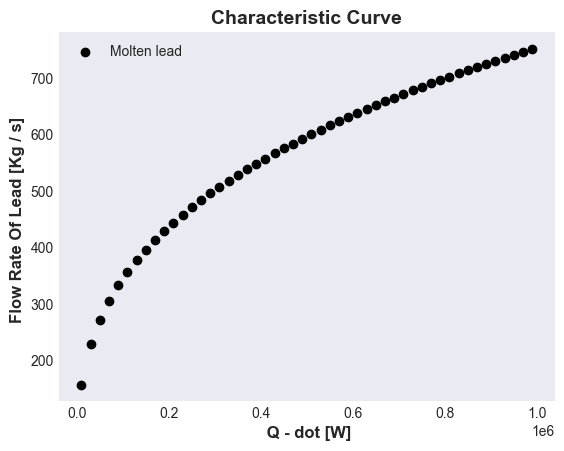

In [106]:
# Plotting the graph
plt.scatter(Q_dot, m_dot_array, color= "black", label= "Molten lead")
plt.legend(loc= "upper left")
plt.xlabel(" Q - dot [W]", fontweight= "bold", fontsize= 12)
plt.ylabel("Flow Rate Of Lead [Kg / s] ", fontweight= "bold", fontsize= 12)
plt.title("Characteristic Curve", fontweight= "bold", fontsize= 14)
plt.show()